In [1]:
%load_ext autoreload
%autoreload 2

# Import 

In [2]:
from bosonic import Qubit, GKPQubit, execute, BosonicRegister, BosonicCircuit, PhaseRotationGate, CDGate
import numpy as np
import matplotlib.pyplot as plt

/home/shanj/miniconda3/envs/jax-new/lib/python3.12/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# Create Bosonic Circuit 

In [3]:
# Circuit containing 1 cavity and 1 qubit
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)

# set up circuit
bcirc.reset() # initialize each qubit in |+z>
bcirc.x(0) # added to gates list
bcirc.x(1) # added to gates list

%timeit -n1 -r1 results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
%timeit results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"

93.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
12.9 µs ± 86.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


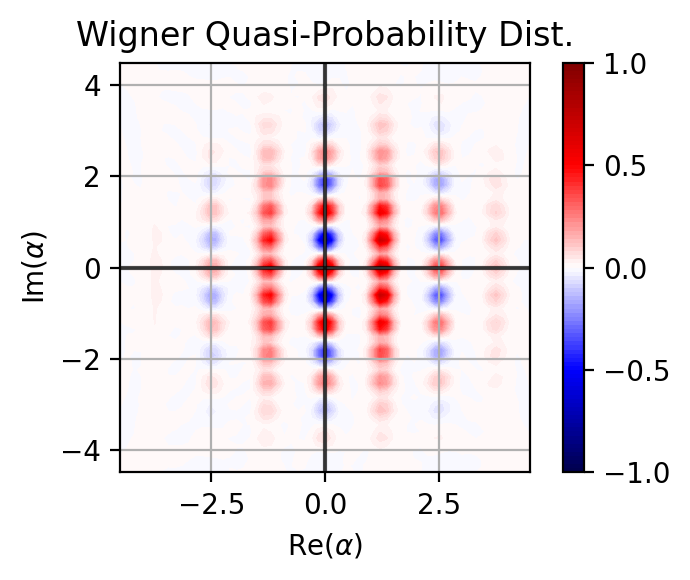

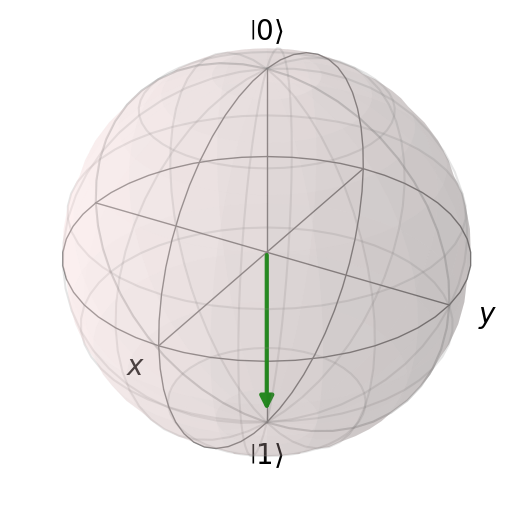

<Figure size 640x480 with 0 Axes>

In [4]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
results.plot(bcirc, 0)
results.plot(bcirc, 1)

# Custom Gates

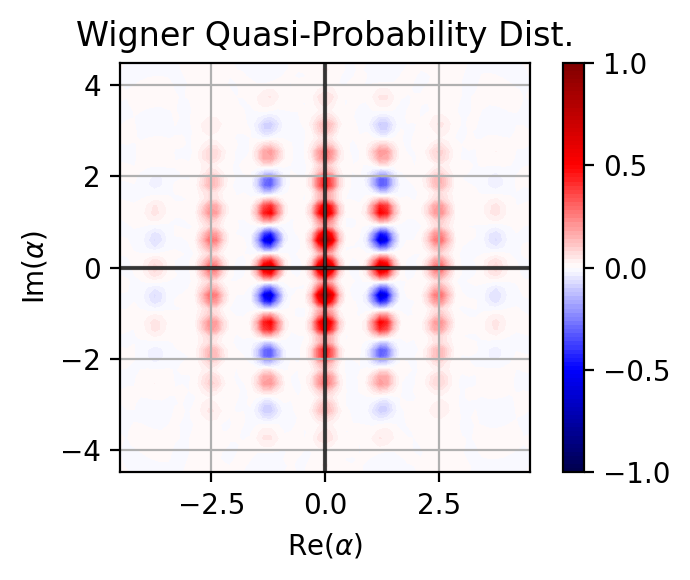

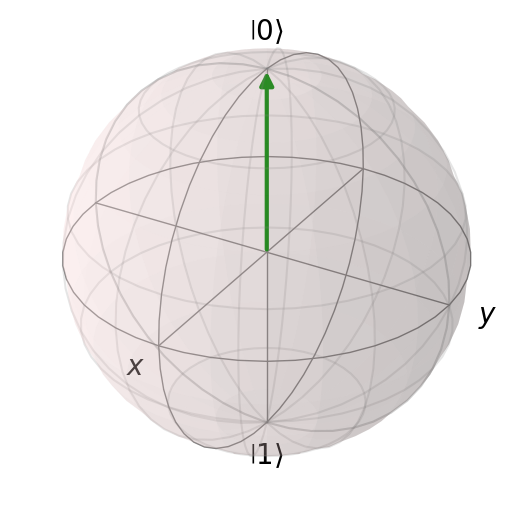

<Figure size 640x480 with 0 Axes>

In [5]:
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)
bcirc.plot(0)
bcirc.plot(1)

In [6]:
breg = BosonicRegister([GKPQubit(),Qubit()]) # [q0,q1]
bcirc = BosonicCircuit(breg)

bcirc.x(1) # add an X Gate on q1
bcirc.add(PhaseRotationGate, 0, {"phi": np.pi/4}) 
bcirc.add(CDGate, (0,1), {"beta": 1}) # q0 is the control

%timeit -n1 -r1 results = execute(bcirc, "unitary_jax")
%timeit results = execute(bcirc, "unitary_jax")

423 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.55 ms ± 19.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


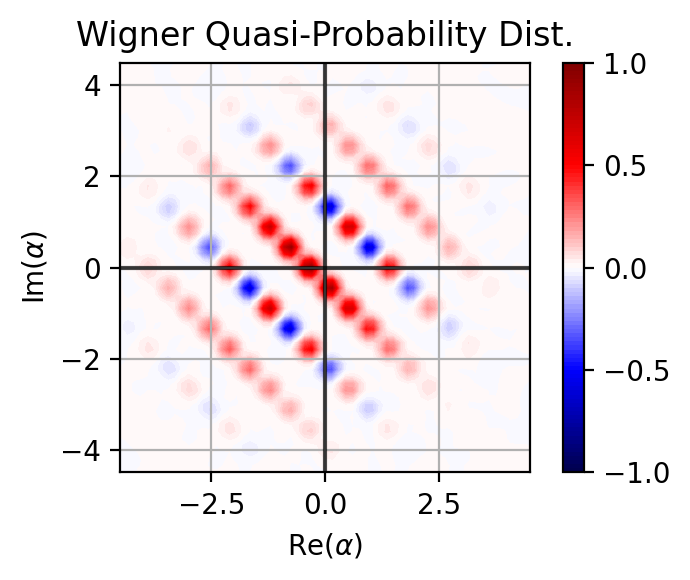

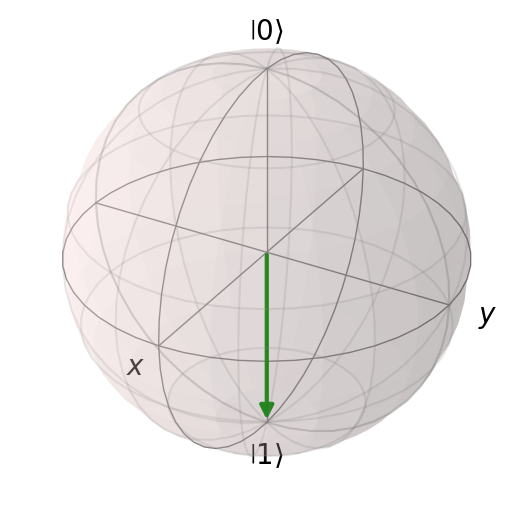

<Figure size 640x480 with 0 Axes>

In [7]:
results = execute(bcirc, "unitary_jax")

results.plot(bcirc, 0) # plot q0
results.plot(bcirc, 1) # plot q1

In [8]:
%timeit results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"

2.56 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


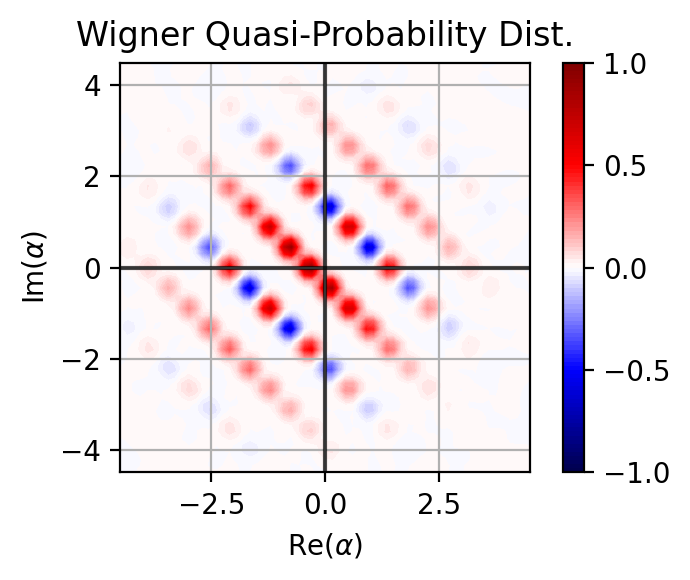

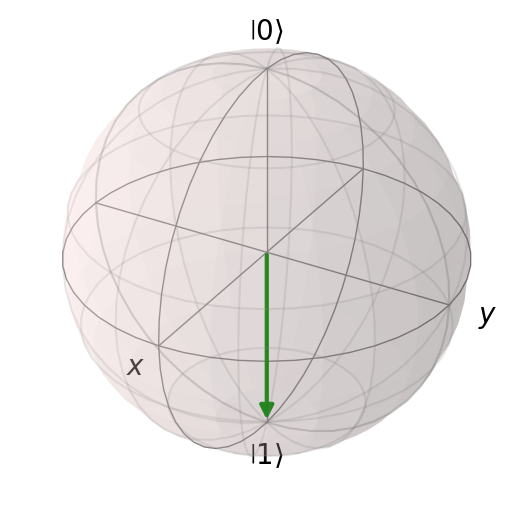

<Figure size 640x480 with 0 Axes>

In [9]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
results.plot(bcirc, 0)
results.plot(bcirc, 1)